In [ ]:
import torchaudio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [ ]:
def plot_mfcc(mfcc):
    # Convert MFCC tensor to numpy array and squeeze extra dimensions
    mfcc_np = mfcc.squeeze().numpy()

    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(12, 4))

    # Display the MFCC spectrogram
    img = ax.imshow(mfcc_np, aspect='auto', origin='lower', interpolation='nearest')

    # Add a colorbar
    cbar = fig.colorbar(img, ax=ax)
    cbar.set_label('Magnitude')

    # Set the title and labels
    ax.set_title('MFCC Spectrogram')
    ax.set_xlabel('Time')
    ax.set_ylabel('MFCC Coefficients')

    # Show the plot
    plt.tight_layout()
    plt.show()

# Download dataset

In [ ]:
!gdown 1cS110V7NiHxmNDyCG5wfkKS5Bk9A1IEW

Downloading...
From (original): https://drive.google.com/uc?id=1cS110V7NiHxmNDyCG5wfkKS5Bk9A1IEW
From (redirected): https://drive.google.com/uc?id=1cS110V7NiHxmNDyCG5wfkKS5Bk9A1IEW&confirm=t&uuid=d1a5bb53-0ba7-47bd-81e2-833d49a57560
To: /content/audio.rar
100% 188M/188M [00:01<00:00, 187MB/s]


In [ ]:
!unrar x audio.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from audio.rar

Creating    audio                                                     OK
Creating    audio/battery                                             OK
Creating    audio/battery/dodaj                                       OK
Extracting  audio/battery/dodaj/ahxwfmvc.wav                               0%  OK 
Extracting  audio/battery/dodaj/akycidkg.wav                               0%  OK 
Extracting  audio/battery/dodaj/amrlswgy.wav                               0%  OK 
Extracting  audio/battery/dodaj/amuxyptm.wav                               0%  OK 
Extracting  audio/battery/dodaj/anjextsy.wav                               0%  OK 
Extracting  audio/battery/dodaj/asvwcakl.wav                               0%  OK 
Extracting  audio/battery/dodaj/bgbzcywc.wav                               0%  OK 
Extracting  audio/battery/dodaj/bg

In [ ]:
!rm -r audio/crema

In [ ]:
class_names = np.array(['battery', 'chew-gum', 'chocolate','cigaretes', 'lighter', 'pen', 'screwdriver', 'usb'])
number_of_classes = len(class_names)
number_of_classes

8

# Create dataset

## Create dataframe

In [ ]:
data = {'path':[], 'label':[]}
import shutil
import os
for folders in os.listdir('audio'):
  for fol in os.listdir(f"audio/{folders}"):
    for file in os.listdir(f"audio/{folders}/{fol}"):
      data['path'].append(f'audio/{folders}/{fol}/{file}')
      data['label'].append(np.where(class_names==folders)[0][0])

In [ ]:
df = pd.DataFrame(data)

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2)

## Create Custom dataset object

In [ ]:
class AudioDataset(Dataset):
  def __init__(self, dataset, transform, label_transform = None, squeeze = True, shrink_data=None):
    super(AudioDataset,self).__init__()
    self.dataset = dataset
    self.transform = transform
    self.label_transform = label_transform
    self.squeeze = squeeze
    self.shrink_data = shrink_data

  def __len__(self):
      return len(self.dataset)

  def __getitem__(self, idx):
    # get audio data
    x, sample_rate = torchaudio.load(self.dataset.iloc[idx].path, normalize=True)
    data = self.transform(x)

    # get label
    label = self.dataset.iloc[idx].label
    # transfrom data
    if self.squeeze:
      data = data.squeeze()

    if self.label_transform:
      label = self.label_transform(label)

    if self.shrink_data:
      data = data[:,int(data.size(1)*self.shrink_data):]

    return data, label

In [ ]:
transformer = transforms.MFCC(
    sample_rate=48000,
    n_mfcc = 40,
    melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 53, "center": False},
)

## Load datasets

In [ ]:
train_dataset = AudioDataset(df_train,transformer,shrink_data=0.15)
test_dataset = AudioDataset(df_test,transformer,shrink_data=0.15)

In [ ]:
len(train_dataset), len(test_dataset)

## Initilize DataLoaders

In [ ]:
def collate_pad_sequences(batch):
    # Assuming each item in batch is a tuple (data, label)
    # Sort the batch in descending order of length
    #sorted_batch = sorted(batch, key=lambda x: x[0].shape[0], reverse=True)

    # Separate data and labels
    data = []
    labels = [x[1] for x in batch]

    # Pad mfcc with pre-padding 0
    max_len= np.max([x[0].size(1) for x in batch])
    for x in batch:
      mfcc = torch.cat((torch.zeros(x[0].size(0),max_len-x[0].size(1)), x[0]),1)
      data.append(mfcc)

    labels = torch.tensor(labels)
    data = torch.tensor(np.array(data))
    return data, labels


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_pad_sequences)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, collate_fn=collate_pad_sequences)

In [ ]:
for i, _ in train_loader:
  print(i.shape)
  break

# Create Model

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
class RNN(nn.Module):
  def __init__(self, n_inputs,n_hidden,n_layers,n_outputs):
    super(RNN,self).__init__()
    self.D=n_inputs
    self.M=n_hidden
    self.L=n_layers
    self.K=n_outputs

    self.rnn = nn.LSTM(input_size=self.D,
                       hidden_size=self.M,
                       num_layers=self.L,
                       batch_first=True)

    self.fc = nn.Sequential(
          nn.Linear(self.M,1024),
          nn.ReLU(),
          nn.Linear(1024, self.K),
          nn.ReLU()
      )

  def forward(self,X):
    X = X.permute(0,2,1)

    h0= torch.zeros(self.L,X.size(0),self.M).to(device)
    c0= torch.zeros(self.L,X.size(0),self.M).to(device)

    # pass through rnn
    out,_=self.rnn(X,(h0,c0))

    out = self.fc(out[:,-1,:])
    out = F.relu(out)
    return out


In [ ]:
class CNN(nn.Module):
  def __init__(self, n_inputs, n_outputs):
    super(CNN,self).__init__()
    self.D = n_inputs
    self.K = n_outputs
    self.conv1 = nn.Sequential(
      nn.Conv2d(self.D, 32, kernel_size=12, padding=2),
      #nn.ReLU(),
      #nn.Conv2d(32, 64, kernel_size=5),
     # nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.MaxPool2d(2,stride=2)
    )

    self.conv2 = nn.Sequential(
      nn.Conv2d(32, 128, kernel_size=5),
      #nn.ReLU(),
      #nn.Conv2d(128, 256, kernel_size=2),
      #nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.MaxPool2d(2)
    )

    self.conv3 = nn.Sequential(
      nn.Conv2d(128, 512, kernel_size=2),
      nn.BatchNorm2d(512),
      nn.ReLU(),
      nn.MaxPool2d(2)
    )
    self.conv4 = nn.Sequential(
      nn.Conv2d(512, 384, kernel_size=2),
     # nn.BatchNorm2d(384),
      nn.ReLU(),
     # nn.MaxPool2d(2)
    )
    self.conv5 = nn.Sequential(
      nn.Conv2d(384, 384, kernel_size=2),
      nn.BatchNorm2d(384),
      nn.ReLU(),
      #nn.MaxPool2d(2)
    )
    self.fc = nn.Sequential(
      nn.Dropout(0.5),
      nn.Linear(384,1024),
      nn.ReLU(),
      #nn.Linear(1024, 512),
      #nn.ReLU(),
      nn.Linear(1024, self.K),
      nn.ReLU()
    )

  def forward(self,X):
    X = torch.unsqueeze(X,1)

    out = self.conv1(X)

    out = self.conv2(out)

    out = self.conv3(out)

    out = self.conv4(out)
    out = self.conv5(out)

    out, _  = torch.max(out, -1)
    out = out.view(out.size(0), -1)
    out = self.fc(out)
    return out



In [ ]:
class ComposedModel(nn.Module):
  def __init__(self, rnn_inputs,rnn_hidden,rnn_layers,hidden_outputs, n_outputs):
    super(ComposedModel,self).__init__()
    self.D=rnn_inputs
    self.M=rnn_hidden
    self.L=rnn_layers
    self.HO=hidden_outputs
    self.K = n_outputs

    self.rnn = RNN(n_inputs=self.D,
                   n_hidden=self.M,
                   n_layers=self.L,
                   n_outputs=self.HO)
    self.cnn = CNN(n_inputs=1, n_outputs=self.HO)

    self.fc = nn.Sequential(
        nn.Linear(self.HO+2,4096),
        nn.ReLU(),
        nn.Linear(4096,2048),
        nn.ReLU(),
        nn.Linear(2048,1024),
        nn.ReLU(),
        nn.Linear(1024,self.K))

  def forward(self,X):
    rnn_outputs = self.rnn(X)
    cnn_outputs = self.cnn(X)

    out = torch.cat((rnn_outputs,cnn_outputs),1)
    out = self.fc(out)
    return out

In [ ]:
model = ComposedModel(
            rnn_inputs=transformer.n_mfcc,
            rnn_hidden=128,
            rnn_layers=5,
            hidden_outputs = 512,
            n_outputs=number_of_classes)
model.to(device)

ComposedModel(
  (rnn): RNN(
    (rnn): LSTM(40, 128, num_layers=5, batch_first=True)
    (fc): Sequential(
      (0): Linear(in_features=128, out_features=1024, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1024, out_features=512, bias=True)
      (3): ReLU()
    )
  )
  (cnn): CNN(
    (conv1): Sequential(
      (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv2): Sequential(
      (0): Conv2d(32, 128, kernel_size=(5, 5), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv3): Sequential(
      (0): Conv2d(128, 512, kernel_size=(2, 2), stride=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    

In [ ]:
#model = RNN(n_inputs=transformer.n_mfcc,
#            n_hidden=128,
#            n_layers=5,
#            n_outputs=number_of_classes)
#model.to(device)

In [ ]:
#model = CNN(n_inputs=1, n_outputs=number_of_classes)
#model.to(device)

In [ ]:
for i, k in train_loader:
  #print(i.shape)
 # i = i.view(i.size(0),1,i.size(1),i.size(2))


  lak = model(i.to(device))
  print(lak.size())
  break

torch.Size([32, 8])


# Train model

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)

In [ ]:
def save_model_checkpoint(val_loss, best_val_loss, train_loss, it, model=model, optimizer=optimizer,path='model_checkpoint.pt'):
    torch.save({
            'epoch': it,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            }, path)
    print(f'Model saved at epoch: {it+1}, val_loss improved from: {best_val_loss:.4f} to: {val_loss:.4f}')

In [ ]:
def plot_loss_curves(train_losses,val_losses,train_losses2=None,val_losses2=None):
  if(train_losses2 is not None):
    train_losses = np.concatenate((train_losses,train_losses2))
    val_losses = np.concatenate((val_losses,val_losses2))
  plt.plot(train_losses,label='Train loss')
  plt.plot(val_losses,label='Val loss')
  plt.legend(); plt.show
best_val_loss=10**5

In [ ]:
epoches=15
train_losses = np.zeros(epoches)
val_losses = np.zeros(epoches)

for it in range(epoches):
  t0 = datetime.now()
  model.train() # set model to train mode
  train_loss=[]
  val_loss=[]

  # train
  for inputs,targets in train_loader:
    # move data to gpu
    inputs,targets = inputs.to(device),targets.to(device)
    #inputs = inputs.permute(0,2,1)
    # zero gradients
    optimizer.zero_grad()

    # forward pass
    outputs = model(inputs)
    loss = criterion(outputs,targets)

    # backward
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())

  model.eval() # set model to eval mode
  for inputs,targets in test_loader:
    # move data to gpu
    inputs,targets = inputs.to(device),targets.to(device)
   # inputs = inputs.permute(0,2,1)


    # forward pass
    outputs = model(inputs)
    loss = criterion(outputs,targets)

    val_loss.append(loss.item())

  # calculate loss
  train_loss = np.mean(train_loss)
  val_loss = np.mean(val_loss)
  if (val_loss<best_val_loss):
    save_model_checkpoint(val_loss,best_val_loss,train_loss,it, path='model_checkpoint.pt')
    best_val_loss=val_loss
  # append loss
  train_losses[it]=train_loss
  val_losses[it]=val_loss
  dt = datetime.now() - t0
  print(f"Epoch {it+1}/{epoches}, Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}, Duration: {dt}")
  print('-------------------------------------------------------------')

Model saved at epoch: 1, val_loss improved from: 100000.0000 to: 0.4853
Epoch 1/15, Train loss: 0.4238, Val loss: 0.4853, Duration: 0:00:29.190508
-------------------------------------------------------------
Epoch 2/15, Train loss: 0.3423, Val loss: 0.6229, Duration: 0:00:27.952665
-------------------------------------------------------------
Epoch 3/15, Train loss: 0.3306, Val loss: 0.6586, Duration: 0:00:28.022298
-------------------------------------------------------------
Model saved at epoch: 4, val_loss improved from: 0.4853 to: 0.4555
Epoch 4/15, Train loss: 0.2936, Val loss: 0.4555, Duration: 0:00:28.538900
-------------------------------------------------------------
Model saved at epoch: 5, val_loss improved from: 0.4555 to: 0.3672
Epoch 5/15, Train loss: 0.3142, Val loss: 0.3672, Duration: 0:00:28.460179
-------------------------------------------------------------
Model saved at epoch: 6, val_loss improved from: 0.3672 to: 0.3533
Epoch 6/15, Train loss: 0.2284, Val loss: 

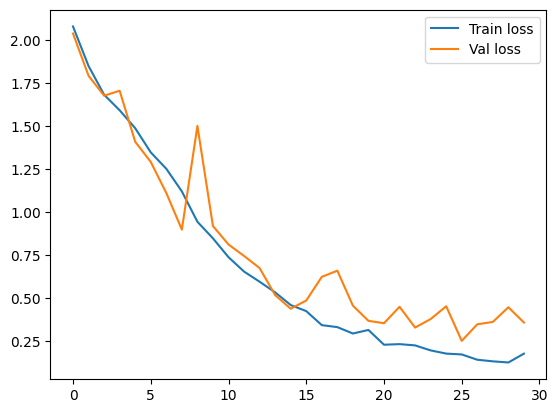

In [ ]:
print_second = True
if print_second:
  plot_loss_curves(train_losses2,val_losses2,train_losses,val_losses,)
else:
  plot_loss_curves(train_losses,val_losses)
  train_losses2,val_losses2 = train_losses,val_losses

In [ ]:
model.eval()
# train accuracy
n_correct=0
n_total=0
for inputs,targets in train_loader:
  # move data to gpu
  inputs,targets = inputs.to(device),targets.to(device)
  #inputs = inputs.permute(0,2,1)

  # make prediction
  outputs = model(inputs)
  _,predictions = torch.max(outputs,1)

  # update counts
  n_correct+=(predictions==targets).sum().item()
  n_total+=targets.shape[0]
train_acc = n_correct/n_total

# test accuracy
n_correct=0
n_total=0
for inputs,targets in test_loader:
  # move data to gpu
  inputs,targets = inputs.to(device),targets.to(device)
  #inputs = inputs.permute(0,2,1)

  # make prediction
  outputs = model(inputs)
  _,predictions = torch.max(outputs,1)

  # update counts
  n_correct+=(predictions==targets).sum().item()
  n_total+=targets.shape[0]
test_acc = n_correct/n_total

print(f"Train accuracy: {train_acc:.4f}, Test accuracy: {test_acc:.4f}")

NameError: name 'model' is not defined

In [ ]:
train_losses2=train_losses
val_losses2=val_losses

In [ ]:
train_losses,train_losses.shape

(array([0.30328385, 0.22913785, 0.19899785, 0.22594978, 0.20306482,
        0.20859716, 0.18143668, 0.16264521, 0.16369132, 0.12313485,
        0.10760708, 0.13728693, 0.18853074, 0.15131345, 0.11418174]),
 (15,))

[0.30328385 0.22913785 0.19899785 0.22594978 0.20306482 0.20859716
 0.18143668 0.16264521 0.16369132 0.12313485 0.10760708 0.13728693
 0.18853074 0.15131345 0.11418174 0.30328385 0.22913785 0.19899785
 0.22594978 0.20306482 0.20859716 0.18143668 0.16264521 0.16369132
 0.12313485 0.10760708 0.13728693 0.18853074 0.15131345 0.11418174]


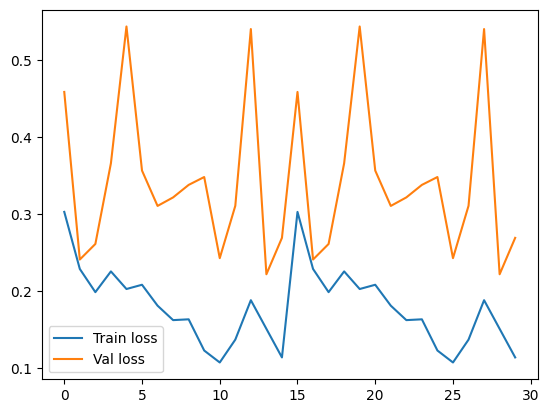

In [ ]:
plot_loss_curves(train_losses,val_losses,train_losses2,val_losses2)

# Save the model

In [ ]:
torch.save(model.state_dict(), 'mysecondmodel.pt')

In [ ]:
Train accuracy: 0.8651, Test accuracy: 0.7956


SyntaxError: invalid syntax (<ipython-input-94-5a82377ac920>, line 1)

In [ ]:
optimizer.param_groups[0]['lr'] =0.00005

In [ ]:
optimizer.param_groups[0]['lr']

In [ ]:
np.zeros(10)+np.zeros(10)

In [ ]:
for param in model.rnn.parameters():
  param.requires_grad=False

# Load model and make predictions

In [ ]:
loaded_model = ComposedModel(
            rnn_inputs=transformer.n_mfcc,
            rnn_hidden=128,
            rnn_layers=5,
            hidden_outputs = 512,
            n_outputs=number_of_classes)
loaded_model.to(device)

ComposedModel(
  (rnn): RNN(
    (rnn): LSTM(40, 128, num_layers=5, batch_first=True)
    (fc): Sequential(
      (0): Linear(in_features=128, out_features=1024, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1024, out_features=512, bias=True)
      (3): ReLU()
    )
  )
  (cnn): CNN(
    (conv1): Sequential(
      (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv2): Sequential(
      (0): Conv2d(32, 128, kernel_size=(5, 5), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv3): Sequential(
      (0): Conv2d(128, 512, kernel_size=(2, 2), stride=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    

In [ ]:
loaded_model.load_state_dict(torch.load('model_checkpoint.pt',map_location=device)['model_state_dict'])
loaded_model.eval()
#model.to(device)

NameError: name 'loaded_model' is not defined

In [ ]:
x, sample_rate = torchaudio.load('/content/anel.wav', normalize=True)
#x = x[:,int(data.size(1)*0.2):]
data = transformer(x)
data = data.squeeze()
data = torch.unsqueeze(data,dim=0)
data=data.to(device)

RuntimeError: Failed to open the input "/content/anel.wav" (No such file or directory).
Exception raised from get_input_format_context at /__w/audio/audio/pytorch/audio/src/libtorio/ffmpeg/stream_reader/stream_reader.cpp:42 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x96 (0x7da60008ef86 in /usr/local/lib/python3.10/dist-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::string const&) + 0x64 (0x7da60003dd10 in /usr/local/lib/python3.10/dist-packages/torch/lib/libc10.so)
frame #2: <unknown function> + 0x41ff4 (0x7da5e3e80ff4 in /usr/local/lib/python3.10/dist-packages/torio/lib/libtorio_ffmpeg4.so)
frame #3: torio::io::StreamingMediaDecoder::StreamingMediaDecoder(std::string const&, std::optional<std::string> const&, std::optional<std::map<std::string, std::string, std::less<std::string>, std::allocator<std::pair<std::string const, std::string> > > > const&) + 0x14 (0x7da5e3e839f4 in /usr/local/lib/python3.10/dist-packages/torio/lib/libtorio_ffmpeg4.so)
frame #4: <unknown function> + 0x3aa7e (0x7da4e03a2a7e in /usr/local/lib/python3.10/dist-packages/torio/lib/_torio_ffmpeg4.so)
frame #5: <unknown function> + 0x32647 (0x7da4e039a647 in /usr/local/lib/python3.10/dist-packages/torio/lib/_torio_ffmpeg4.so)
frame #6: <unknown function> + 0x15adae (0x58297bd8adae in /usr/bin/python3)
frame #7: _PyObject_MakeTpCall + 0x25b (0x58297bd8152b in /usr/bin/python3)
frame #8: <unknown function> + 0x169680 (0x58297bd99680 in /usr/bin/python3)
frame #9: <unknown function> + 0x165dc7 (0x58297bd95dc7 in /usr/bin/python3)
frame #10: <unknown function> + 0x1518db (0x58297bd818db in /usr/bin/python3)
frame #11: <unknown function> + 0xf6bb (0x7da61944c6bb in /usr/local/lib/python3.10/dist-packages/torchaudio/lib/_torchaudio.so)
frame #12: _PyObject_MakeTpCall + 0x25b (0x58297bd8152b in /usr/bin/python3)
frame #13: _PyEval_EvalFrameDefault + 0x6f0b (0x58297bd7a16b in /usr/bin/python3)
frame #14: _PyObject_FastCallDictTstate + 0xc4 (0x58297bd806c4 in /usr/bin/python3)
frame #15: <unknown function> + 0x1657a4 (0x58297bd957a4 in /usr/bin/python3)
frame #16: _PyObject_MakeTpCall + 0x1fc (0x58297bd814cc in /usr/bin/python3)
frame #17: _PyEval_EvalFrameDefault + 0x6f0b (0x58297bd7a16b in /usr/bin/python3)
frame #18: _PyFunction_Vectorcall + 0x7c (0x58297bd8b6ac in /usr/bin/python3)
frame #19: _PyEval_EvalFrameDefault + 0x6d5 (0x58297bd73935 in /usr/bin/python3)
frame #20: _PyFunction_Vectorcall + 0x7c (0x58297bd8b6ac in /usr/bin/python3)
frame #21: _PyEval_EvalFrameDefault + 0x64e2 (0x58297bd79742 in /usr/bin/python3)
frame #22: _PyFunction_Vectorcall + 0x7c (0x58297bd8b6ac in /usr/bin/python3)
frame #23: _PyEval_EvalFrameDefault + 0x19b6 (0x58297bd74c16 in /usr/bin/python3)
frame #24: <unknown function> + 0x140096 (0x58297bd70096 in /usr/bin/python3)
frame #25: PyEval_EvalCode + 0x86 (0x58297be65f66 in /usr/bin/python3)
frame #26: <unknown function> + 0x23ba2d (0x58297be6ba2d in /usr/bin/python3)
frame #27: <unknown function> + 0x15b909 (0x58297bd8b909 in /usr/bin/python3)
frame #28: _PyEval_EvalFrameDefault + 0x6d5 (0x58297bd73935 in /usr/bin/python3)
frame #29: <unknown function> + 0x1788d0 (0x58297bda88d0 in /usr/bin/python3)
frame #30: _PyEval_EvalFrameDefault + 0x2891 (0x58297bd75af1 in /usr/bin/python3)
frame #31: <unknown function> + 0x1788d0 (0x58297bda88d0 in /usr/bin/python3)
frame #32: _PyEval_EvalFrameDefault + 0x2891 (0x58297bd75af1 in /usr/bin/python3)
frame #33: <unknown function> + 0x1788d0 (0x58297bda88d0 in /usr/bin/python3)
frame #34: <unknown function> + 0x2566ff (0x58297be866ff in /usr/bin/python3)
frame #35: <unknown function> + 0x16700a (0x58297bd9700a in /usr/bin/python3)
frame #36: _PyEval_EvalFrameDefault + 0x8cb (0x58297bd73b2b in /usr/bin/python3)
frame #37: _PyFunction_Vectorcall + 0x7c (0x58297bd8b6ac in /usr/bin/python3)
frame #38: _PyEval_EvalFrameDefault + 0x6d5 (0x58297bd73935 in /usr/bin/python3)
frame #39: _PyFunction_Vectorcall + 0x7c (0x58297bd8b6ac in /usr/bin/python3)
frame #40: _PyEval_EvalFrameDefault + 0x8cb (0x58297bd73b2b in /usr/bin/python3)
frame #41: <unknown function> + 0x169251 (0x58297bd99251 in /usr/bin/python3)
frame #42: PyObject_Call + 0x122 (0x58297bd99f02 in /usr/bin/python3)
frame #43: _PyEval_EvalFrameDefault + 0x2a49 (0x58297bd75ca9 in /usr/bin/python3)
frame #44: <unknown function> + 0x169251 (0x58297bd99251 in /usr/bin/python3)
frame #45: _PyEval_EvalFrameDefault + 0x19b6 (0x58297bd74c16 in /usr/bin/python3)
frame #46: <unknown function> + 0x201a15 (0x58297be31a15 in /usr/bin/python3)
frame #47: <unknown function> + 0x15b909 (0x58297bd8b909 in /usr/bin/python3)
frame #48: <unknown function> + 0x2378e5 (0x58297be678e5 in /usr/bin/python3)
frame #49: <unknown function> + 0x2b42c2 (0x58297bee42c2 in /usr/bin/python3)
frame #50: <unknown function> + 0x14e44b (0x58297bd7e44b in /usr/bin/python3)
frame #51: _PyEval_EvalFrameDefault + 0x6d5 (0x58297bd73935 in /usr/bin/python3)
frame #52: _PyFunction_Vectorcall + 0x7c (0x58297bd8b6ac in /usr/bin/python3)
frame #53: _PyEval_EvalFrameDefault + 0x8cb (0x58297bd73b2b in /usr/bin/python3)
frame #54: <unknown function> + 0x201a15 (0x58297be31a15 in /usr/bin/python3)
frame #55: <unknown function> + 0x15b909 (0x58297bd8b909 in /usr/bin/python3)
frame #56: <unknown function> + 0x2378e5 (0x58297be678e5 in /usr/bin/python3)
frame #57: <unknown function> + 0x2b42c2 (0x58297bee42c2 in /usr/bin/python3)
frame #58: <unknown function> + 0x14e44b (0x58297bd7e44b in /usr/bin/python3)
frame #59: _PyEval_EvalFrameDefault + 0x6d5 (0x58297bd73935 in /usr/bin/python3)
frame #60: <unknown function> + 0x169251 (0x58297bd99251 in /usr/bin/python3)
frame #61: _PyEval_EvalFrameDefault + 0x6d5 (0x58297bd73935 in /usr/bin/python3)
frame #62: <unknown function> + 0x201a15 (0x58297be31a15 in /usr/bin/python3)


In [ ]:
data.device

In [ ]:
outputs = model(data)
results = F.softmax(outputs,dim=1)

In [ ]:
results

In [ ]:
class_names[torch.argmax(results)],results[0,2]

In [ ]:
import IPython.display as display
import random

In [ ]:
display.display(display.Audio(x, rate=48000))

In [ ]:
plt.bar(class_names,results[0].cpu().detach().numpy())


In [ ]:
results[0].cpu().detach().numpy()

In [ ]:
loaded_model.eval()
# train accuracy
n_correct=0
n_total=0
for inputs,targets in train_loader:
  # move data to gpu
  inputs,targets = inputs.to(device),targets.to(device)
  #inputs = inputs.permute(0,2,1)

  # make prediction
  outputs = loaded_model(inputs)
  _,predictions = torch.max(outputs,1)

  # update counts
  n_correct+=(predictions==targets).sum().item()
  n_total+=targets.shape[0]
train_acc = n_correct/n_total

# test accuracy
n_correct=0
n_total=0
for inputs,targets in test_loader:
  # move data to gpu
  inputs,targets = inputs.to(device),targets.to(device)
  #inputs = inputs.permute(0,2,1)

  # make prediction
  outputs = loaded_model(inputs)
  _,predictions = torch.max(outputs,1)

  # update counts
  n_correct+=(predictions==targets).sum().item()
  n_total+=targets.shape[0]
test_acc = n_correct/n_total

print(f"Train accuracy: {train_acc:.4f}, Test accuracy: {test_acc:.4f}")

Train accuracy: 0.9723, Test accuracy: 0.9138


In [ ]:
torch.save(loaded_model.state_dict(), 'mythirdmodel.pt')